# Langchain introduction

This notebook introduces how to work with Langchain. 
Made by Csaba Hegedűs, BME-TMIT. 

## Chapter 0 Setup

### Python packages 
Installing prerequisites: langchain and langgraph libraries

In [2]:
!pip install --quiet langchain langchain-community langchain-openai

### Configure LLM

Always run this, before trying out anything else. 

You can use OpenAI or AzureOpenAI. 

ALTERNATIVE: Using AzureOpenAI instance as LLM

In [75]:
AZURE_OPENAI_ENDPOINT = ""
AZURE_OPENAI_API_KEY = ""
AZURE_OPENAI_API_VERSION = "2024-05-01-preview"
AZURE_OPENAI_DEPLOYMENT_NAME = "gpt4o"

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_OPENAI_API_VERSION,
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
)

ALTERNATIVE: Using OpenAI as LLM

In [74]:
OPENAI_API_KEY = ""

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o")

## Chapter 1: setup & fundamentals

### Simple executable chains

References:
https://python.langchain.com/v0.1/docs/get_started/quickstart/


https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html


In [2]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You make jokes about the user's input."),
    ("user", "{input}")
])

#langchain specific code to chain the prompt and the llm
chain = prompt | llm 

response = chain.invoke({"input": "I think LLMs make good romantical companions."})
response.pretty_print()

================================== Ai Message ==================================

Well, I guess you could say an LLM always has the "write" words to say! But be careful—they might just ghost you by running out of battery! 😜


See how many tokens the chain used

In [4]:
print(f'OpenAI: {response.response_metadata["token_usage"]}\n')

OpenAI: {'completion_tokens': 41, 'prompt_tokens': 30, 'total_tokens': 71}



Simple chain using streaming 

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You make jokes about the user's input."),
    ("user", "{input}")
])

#langchain specific code to chain the prompt and the llm
chain = prompt | llm 

chunks = []
for chunk in chain.stream({"input": "I think LLMs make good romantical companions."}):
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

|Well|,| as| an| L|LM|,| I| can| definitely| help| you| find| the| perfect| words| for| a| love| letter|,| but| if| you| ask| me| to| go| on| a| dinner| date|,| I| might| just| end| up| "|byte|"-|ing| more| than| I| can| chew|!||

### Chat prompt templates in details

References:
https://python.langchain.com/v0.2/docs/concepts/#prompt-templates


In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

SYSTEM_PROMPT_RAW = """
    You are a helpful assistant. You are asked to help the user with their questions.
    """

prompt_no_examples =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_RAW), 
    MessagesPlaceholder(variable_name="conversation"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

prompt_no_examples.pretty_print()

================================ System Message ================================


    You are a helpful assistant. You are asked to help the user with their questions.
    

============================= Messages Placeholder =============================

{conversation}

================================ Human Message =================================

{input}


In [16]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

SYSTEM_PROMPT_RAW = """
    You are a helpful assistant. You are asked to help the user with their questions.
    """

prompt_no_examples =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_RAW), 
    MessagesPlaceholder(variable_name="conversation"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

previous_conversation = [
    HumanMessage(content="What is BME-TMIT?"),
    AIMessage(content="BME-TMIT is a department at the Budapest University of Technology and Economics."),
    HumanMessage(content="What does it stand for?"),
    AIMessage(content="BME-TMIT stands for Budapest University of Technology and Economics, Department of Telecommunications and Media Informatics.")
]

#this generates an array of messages 
array_partial_prompt = prompt_no_examples.format_messages(conversation=previous_conversation, input="Who is the head of the department?")

#we can create a new prompt template from the array of messages to pretty print
partial_prompt = ChatPromptTemplate.from_messages(array_partial_prompt)
partial_prompt.pretty_print()



================================ System Message ================================


    You are a helpful assistant. You are asked to help the user with their questions.
    

================================ Human Message =================================

What is BME-TMIT?

================================== Ai Message ==================================

BME-TMIT is a department at the Budapest University of Technology and Economics.

================================ Human Message =================================

What does it stand for?

================================== Ai Message ==================================

BME-TMIT stands for Budapest University of Technology and Economics, Department of Telecommunications and Media Informatics.

================================ Human Message =================================

Who is the head of the department?


Quickly run the chain through to get an answer

In [18]:
funny_response = chain.invoke(array_partial_prompt)
funny_response.pretty_print()

================================== Ai Message ==================================

The head of the department? Well, they say it's the person who can untangle the most Ethernet cables in under a minute! But seriously, the head of the Department of Telecommunications and Media Informatics at BME is a faculty member appointed by the university. You might want to check the latest details on their official website because, you know, academic heads change faster than Wi-Fi passwords!


Ok, so this responds well. However, it still makes jokes of the user input, why??

It is because the chain contains the original "make joke of user input" system prompt, even though we append another system prompt as well in the invoke with *array_partial_prompt* !!

### Few shot examples 

Ref: https://python.langchain.com/v0.2/docs/how_to/few_shot_examples_chat/

I only show static examples, but we can build RAG pipeline to supply relevant examples based on user query as well

In [23]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples_template = ChatPromptTemplate.from_messages(
    [
        ("human", "EXAMPLE: {input}"),
        ("ai", "EXAMPLE: {output}"),
    ]
)

examples = [
    {
        "input": "What does BME-TMIT specialize in?",
        "output": "BME-TMIT specializes in telecommunications and media informatics."
    },
    {
        "input": "What is the best programming language?",
        "output": "The best programming language is Java."
    }
]

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=examples_template,
    examples=examples,
)

print(few_shot_prompt.format_messages())

[HumanMessage(content='EXAMPLE: What does BME-TMIT specialize in?'), AIMessage(content='EXAMPLE: BME-TMIT specializes in telecommunications and media informatics.'), HumanMessage(content='EXAMPLE: What is the best programming language?'), AIMessage(content='EXAMPLE: The best programming language is Java.')]


Put all this together! 

In [24]:
SYSTEM_PROMPT_EXAMPLES_RAW = """
    You are a helpful assistant.
    You are asked to help the user with their questions.
    Do not make jokes about the user's input.
    """

prompt_with_history_and_examples =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_EXAMPLES_RAW), 
    few_shot_prompt,
    MessagesPlaceholder(variable_name="conversation"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

array_examples_prompt = prompt_with_history_and_examples.format_messages(conversation=previous_conversation, input="Who is the head of the department?")
#we can create a new prompt template from the array of messages to pretty print
partial_prompt_2 = ChatPromptTemplate.from_messages(array_examples_prompt)
partial_prompt_2.pretty_print()

================================ System Message ================================


    You are a helpful assistant.
    You are asked to help the user with their questions.
    Do not make jokes about the user's input.
    

================================ Human Message =================================

EXAMPLE: What does BME-TMIT specialize in?

================================== Ai Message ==================================

EXAMPLE: BME-TMIT specializes in telecommunications and media informatics.

================================ Human Message =================================

EXAMPLE: What is the best programming language?

================================== Ai Message ==================================

EXAMPLE: The best programming language is Java.

================================ Human Message =================================

What is BME-TMIT?

================================== Ai Message ==================================

BME-TMIT is a department at the Budapest Unive

### Callbacks

We can tap into events of a chain being executed. 
Ref: https://python.langchain.com/v0.2/docs/how_to/callbacks_attach/ 

In [ ]:
BTD

### Simple chat history 

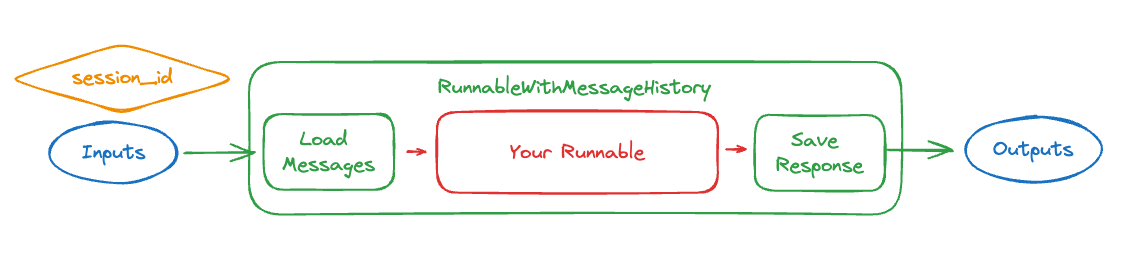

Ref: https://python.langchain.com/v0.2/docs/how_to/message_history/

Possible memory providers: https://python.langchain.com/v0.2/docs/integrations/platforms/

In [34]:
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage

SYSTEM_PROMPT_RAW = """
    You are a helpful assistant. You are asked to help the user with their questions.
    """

prompt_with_history = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT_RAW),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

chain_without_history = prompt_with_history | llm

def get_session_history(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

chain_with_history = RunnableWithMessageHistory(
    chain_without_history,
    get_session_history,
    history_messages_key = "history",
    input_messages_key="input",
)

response_1 = chain_with_history.invoke(
    {"input":"Hi! My name is Csaba!"},
    config={"configurable": {"session_id": "1"}},
)
print(response_1)

response_2 = chain_with_history.invoke(
    {"input":"I love dogs!"},
    config={"configurable": {"session_id": "1"}},
)
print(response_2)

response_3 = chain_with_history.invoke(
    {"input":"I love potatoes!"},
    config={"configurable": {"session_id": "1"}},
)
print(response_3)

response_4 = chain_with_history.invoke(
    {"input":"What is my name and what do I love?"},
    config={"configurable": {"session_id": "1"}},
)
print(response_4)



history = chain_with_history.get_session_history("1").get_messages()
history_prompt = ChatPromptTemplate.from_messages(history)
history_prompt.pretty_print()

chain_with_history.get_session_history("1").clear()

Parent run a220d218-02d9-476f-b72a-d2422d8a9e26 not found for run c22d452f-2a56-43d0-8900-c1739cbdd117. Treating as a root run.
Parent run 31f4eb25-a337-489c-9466-d7533833be2a not found for run 509e48d8-1fc6-4e98-871a-37764c2e13d9. Treating as a root run.


content='Hello Csaba! How can I assist you today?' response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 251, 'total_tokens': 263}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='run-5430b025-ad91-4911-ab42-0ff2336d1e02-0' usage_metadata={'input_tokens': 251, 'output_tokens': 12, 'total_tokens': 263}


Parent run c2c655e4-0c7a-4b5d-87c9-903e62de9999 not found for run afe12c48-59d4-4e08-bb1f-6bede3fe8b3d. Treating as a root run.


content="That's wonderful, Csaba! Dogs are amazing companions. Do you have a dog, or are you thinking about getting one?" response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 274, 'total_tokens': 300}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='run-4f40c73c-26b8-4a54-826d-3578939b0213-0' usage_metadata={'input_tokens': 274, 'output_tokens': 26, 'total_tokens': 300}


Parent run 9ae7dcbf-ee08-47ff-aa3b-85a4c6b29db4 not found for run 4be32455-8f11-4883-95e8-7df2154ff517. Treating as a root run.


content='Potatoes are incredibly versatile and delicious! They can be prepared in so many ways—mashed, fried, roasted, baked, and more. Do you have a favorite potato dish?' response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 311, 'total_tokens': 349}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='run-01530999-836d-458c-8b26-90294e095b31-0' usage_metadata={'input_tokens': 311, 'ou

## Chapter 2 Advanced prompting scenarios

### Using structured output

This is useful if you need to force LLM output to be a specific schema, e.g. JSON. 
This uses Pydantic objects as schemas and then parses output to schema. 

Potential use case: synthetic dataset generation

Ref: https://python.langchain.com/v0.2/docs/how_to/structured_output/#the-with_structured_output-method

In [58]:
from typing import Optional
from langchain_core.pydantic_v1 import BaseModel, Field

class TestCase(BaseModel):
    """A structured test case for a web service"""

    url: str = Field(description="The URL of the web service")
    method: str = Field(description="The HTTP method to use")
    headers: Optional[str] = Field(description="The headers of the request")
    body: Optional[str] = Field(description="The body of the request")
    expected_status: int = Field(description="The expected HTTP status code of the response")
    expected_body: Optional[str] = Field(description="The expected body of the response")

structured_llm = llm.with_structured_output(TestCase)

structured_response_get = structured_llm.invoke("Write a test case that uses Swagger Petstore specification to get a pet by ID.")
print(structured_response_get)

structured_response_post = structured_llm.invoke("Write a test case that uses Spotify API specification to add a new favorite song where the user is authenticated with oAuth2. Make up all details for the owner and the song.")
print(structured_response_post)


url='https://petstore.swagger.io/v2/pet/1' method='GET' headers=None body=None expected_status=200 expected_body='{"id":1,"category":{"id":0,"name":"string"},"name":"doggie","photoUrls":["string"],"tags":[{"id":0,"name":"string"}],"status":"available"}'
url='https://api.spotify.com/v1/me/tracks' method='POST' headers='Authorization: Bearer BQDpVgB... (access token)' body='{"ids": ["3n3Ppam7vgaVa1iaRUc9Lp"]}' expected_status=200 expected_body='{"snapshot_id": "MTYwMzM1MDgwMSwwMDAwMDAwMDAwMDAwMTc5YWU0NDU3MzQwMDAwMDE3OGE4MjQy"}'


### Generating pictures (OpenAI Dall-E)

This falls outside of Langchain, but often needed. 
Dall-E is NOT good at generating diagrams or technical documentation. 
If you want that, you need to write a tool that can do that (Chapter 4), e.g. using some Python plot lib. 
Ref: https://platform.openai.com/docs/guides/images/usage

In [59]:
%pip install -q openai

Note: you may need to restart the kernel to use updated packages.


In [76]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

response = client.images.generate(
  model="dall-e-3",
  prompt="a white siamese cat",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url

import base64
import httpx

image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

from IPython.display import Image, display

display(Image(url=image_url))

### Handling multimodal input

Image attachments as input: https://python.langchain.com/v0.2/docs/how_to/multimodal_inputs/

Note: it seems this does not work with LCEL chains at the moment. 

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

multimodal_messages = [
    SystemMessage(content="You make jokes about the user's input."),
    HumanMessage(
        content=[
            {"type": "text", "text": "I have a nice cat."},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
        ]
    )
]

llm.invoke(multimodal_messages)

AIMessage(content="That's a beautiful illustration of a cat! Those blue eyes are mesmerizing. Your cat must be the purr-fect companion!", response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 790, 'total_tokens': 815}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_aa87380ac5', 'finish_reason': 'stop', 'logprobs': None}, id='run-2832c188-0ee8-4f72-afd1-63a1ce17ddcd-0', usage_metadata={'input_tokens': 790, 'output_tokens': 25, 'total_tokens': 815})

## Chapter 3 Tools, agentic workflows

Scenario is a travel agent, who can manage travels (hotels, flights, car rentals). 

This is NOT a true agent prompt yet, only a chatbot that can execute tools. 

### Create mock tools

Ref: https://python.langchain.com/v0.2/docs/how_to/tool_calling/

In [79]:
from langchain.tools import tool

# Non-sensitive tools (GET requests)

@tool
def mock_query_hotel_bookings(user: str) -> str:
    """This tool can be used to fetch information about hotel bookings."""

    return "Current bookings: 2 rooms booked for 3 nights each in Budapest."

@tool
def mock_query_flight_bookins(user: str) -> str:
    """This tool can be used to fetch information about flight bookings."""
    return "Current bookings: 2 flights booked to Budapest from Berlin."

@tool
def mock_query_car_rentals(user: str) -> str:
    """This tool can be used to fetch information about car rentals."""
    return "Current bookings: 1 car rented for 3 days in Budapest."

# Sensitive tools (e.g. POST requests)

@tool
def mock_book_flight(user: str, origin: str, destination: str, date: str) -> str:
    """This sensitive tool can be used to book flights."""
    return f"Flight booked from {origin} to {destination} on {date}. Flight number is LH123 with Lufthansa."

@tool
def mock_book_hotel(user: str, city: str, checkin: str, checkout: str) -> str:
    """This sensitive tool can be used to book hotels."""
    return f"Hotel booked in {city} from {checkin} to {checkout}. Room number is 123."

@tool
def mock_book_car(user: str, city: str, date: str) -> str:
    """This sensitive tool can be used to book cars."""
    return f"Car rented in {city} on {date}. Car model is BMW 3 Series."

### Run a simple tool selector chain

Ref. https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/

In [63]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage

TOOL_SELECTOR_PROMPT_RAW = """
    You are part of a chat assistant that helps users with their travels.
    If none of the available tools are useful, inform the user that you are NOT able to help.

    Important: Always inform the user what is going to be done, especially during tool calls.
    Always verify if you have all the necessary information to use the tool, otherwise ask the user first for the missing information.
    You need to ask for user permission to use sensitive tools.

    If the tool to be used is sensitive (as mentioned in its description), start your response with "sensitive:" in this case.
    HOWEVER, only add "sensitive:" to response content when the exact tool is to be called, not during discussion or follow up questions or while asking for confirmation. 
    Also, don't include "sensitive:" in the response content if the tool to be called is not sensitive.
    You cannot leave input parameters empty  or invalidt values for tool calls!! 
    """

tool_selector_prompt =  ChatPromptTemplate.from_messages([
    SystemMessage(content=TOOL_SELECTOR_PROMPT_RAW), 
    MessagesPlaceholder(variable_name="history"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

plain_tools = [mock_query_hotel_bookings, mock_query_flight_bookins, mock_query_car_rentals]
sensitive_tools = [mock_book_flight, mock_book_hotel, mock_book_car]
all_tools = plain_tools + sensitive_tools
llm = llm.bind_tools(all_tools)

tool_chain = tool_selector_prompt | llm
selector_response = tool_chain.invoke({"input": "What flights do I have booked?", "history" : []})
selector_response.pretty_print()

================================== Ai Message ==================================

I will check your flight bookings for you. Could you please provide me with your name or the user name under which the bookings were made?


Let's see how sensitive tools are called. 

You should also play with the system prompt. See what happens if you remove lines/instructions, etc.

In [64]:
selector_response = tool_chain.invoke({"input": "Book me a flight from Helsinki to Budapest on 2023-01-01. My username is hegeduscs.", "history" : []})
selector_response.pretty_print()

================================== Ai Message ==================================

sensitive: I will now proceed to book a flight for you from Helsinki to Budapest on January 1, 2023.

Let's proceed with the booking.
Tool Calls:
  mock_book_flight (call_j9ICSjzLST5DrGxTrqtGhVkX)
 Call ID: call_j9ICSjzLST5DrGxTrqtGhVkX
  Args:
    user: hegeduscs
    origin: Helsinki
    destination: Budapest
    date: 2023-01-01


### Add chat memory and test a simple agent flow

Let's see how we can create a conversational chatbot with these tools. 

In [65]:
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

def get_session_history(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///tool_agent_memory.db")

tool_chain_with_history = RunnableWithMessageHistory(
    tool_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="history",
)

tool_chain_with_history.get_session_history("1").clear()

Ok, now let's see some actual chatting.

In [66]:
selector_response = tool_chain_with_history.invoke({"input": "Book me a flight to Budapest on 2023-01-01."}, config={"configurable": {"session_id": "1"}},)
selector_response.pretty_print()

Parent run ae9f05dc-5e96-436d-82f8-a256fdebe83c not found for run f50817c2-8806-4f47-aa15-862d6ce536fd. Treating as a root run.


================================== Ai Message ==================================

I can help with booking a flight to Budapest for you. Could you please provide me with your current location (origin city) and your user information to proceed with the booking?


In [67]:
selector_response = tool_chain_with_history.invoke({"input": "hegeduscs and from Helsinki"}, config={"configurable": {"session_id": "1"}},)
selector_response.pretty_print()

Parent run 8cc31486-a655-4af8-a299-c532e71d0afb not found for run 967cae96-44b1-4dbe-b34e-f4376b54ac53. Treating as a root run.


================================== Ai Message ==================================

sensitive: I will now proceed to book a flight for you from Helsinki to Budapest on 2023-01-01.
Tool Calls:
  mock_book_flight (call_wkubXRnkCrKWjH2yB5QARaVj)
 Call ID: call_wkubXRnkCrKWjH2yB5QARaVj
  Args:
    user: hegeduscs
    origin: Helsinki
    destination: Budapest
    date: 2023-01-01


Let's see full chat history so far. 

In [68]:
history = tool_chain_with_history.get_session_history("1").get_messages()
history_prompt = ChatPromptTemplate.from_messages(history)
history_prompt.pretty_print()

================================ Human Message =================================

Book me a flight to Budapest on 2023-01-01.

================================== Ai Message ==================================

I can help with booking a flight to Budapest for you. Could you please provide me with your current location (origin city) and your user information to proceed with the booking?

================================ Human Message =================================

hegeduscs and from Helsinki

================================== Ai Message ==================================

sensitive: I will now proceed to book a flight for you from Helsinki to Budapest on 2023-01-01.
Tool Calls:
  mock_book_flight (call_wkubXRnkCrKWjH2yB5QARaVj)
 Call ID: call_wkubXRnkCrKWjH2yB5QARaVj
  Args:
    user: hegeduscs
    origin: Helsinki
    destination: Budapest
    date: 2023-01-01


Now, we need to execute the tool call ourselves, and insert it into the history. 

In [71]:
from langchain_core.messages import ToolMessage

tool_to_call = selector_response.tool_calls[0]["name"].lower()
selected_tool = next(tool for tool in all_tools if tool.name == tool_to_call)
print(selected_tool)

tool_output = selected_tool.invoke(input=selector_response.tool_calls[0]["args"])
print(tool_output)

tool_response = ToolMessage(content=tool_output, tool_call_id=selector_response.tool_calls[0]["id"])
print(tool_response)

#Be advised, adding this message to the history is not necessary here, we will invoke the model again with the tool response to get the next message
tool_chain_with_history.get_session_history("1").add_message(tool_response)

#Let's see current chat history to see what's next
history = tool_chain_with_history.get_session_history("1").get_messages()
history_prompt = ChatPromptTemplate.from_messages(history)
history_prompt.pretty_print()

name='mock_book_flight' description='This sensitive tool can be used to book flights.' args_schema=<class 'pydantic.v1.main.mock_book_flightSchema'> func=<function mock_book_flight at 0x0000026880F1E8E0>
Flight booked from Helsinki to Budapest on 2023-01-01. Flight number is LH123 with Lufthansa.
content='Flight booked from Helsinki to Budapest on 2023-01-01. Flight number is LH123 with Lufthansa.' tool_call_id='call_wkubXRnkCrKWjH2yB5QARaVj'
================================ Human Message =================================

Book me a flight to Budapest on 2023-01-01.

================================== Ai Message ==================================

I can help with booking a flight to Budapest for you. Could you please provide me with your current location (origin city) and your user information to proceed with the booking?

================================ Human Message =================================

hegeduscs and from Helsinki

================================== Ai Message ========

In [72]:
selector_response = tool_chain_with_history.invoke({"input": []}, config={"configurable": {"session_id": "1"}},)
selector_response.pretty_print()

Parent run 9c9a2874-c625-430f-986a-7d43c183c0ae not found for run 5c80b963-9e5f-46d0-ace8-7e132d5e6a6f. Treating as a root run.


================================== Ai Message ==================================

Your flight from Helsinki to Budapest on 2023-01-01 has been successfully booked. The flight number is LH123 with Lufthansa.

Is there anything else I can assist you with?


## Chapter 4 Agents 

We will do the same but with Langchain/Langgraph agents. 

We are not getting into Langgraph deeply yet, just utilize simple agents from that library. The create_react_agent allows us to be very simple.  

Scenario is the same, tools are same: travel assistant. 

**IMPORTANT**: run the tools section from above first. 

References: 

https://python.langchain.com/v0.2/docs/how_to/migrate_agent/#iterating-through-steps

https://langchain-ai.github.io/langgraph/reference/prebuilt/

In [78]:
%pip install -q langgraph

Note: you may need to restart the kernel to use updated packages.


Create the agent object, give it tools and a system prompt. The checkpointer is the chat memory (in memory). 

In [80]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint import MemorySaver
from langchain_core.messages import SystemMessage

AGENT_SYSTEM_PROMPT = SystemMessage(content="You are a travel assistant. You are asked to help the user with their travel plans.")

plain_tools = [mock_query_hotel_bookings, mock_query_flight_bookins, mock_query_car_rentals]
sensitive_tools = [mock_book_flight, mock_book_hotel, mock_book_car]
all_tools = plain_tools + sensitive_tools

agent = create_react_agent(llm, all_tools, messages_modifier=AGENT_SYSTEM_PROMPT, checkpointer=MemorySaver())
config = {"configurable": {"thread_id": "1"}}

input = {"messages": [("user", "What flights do I have booked?")]}

for s in agent.stream(input, config, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

What flights do I have booked?
================================== Ai Message ==================================
Tool Calls:
  mock_query_flight_bookins (call_QnTZj0YJa3VDmAPpZcEJbgfY)
 Call ID: call_QnTZj0YJa3VDmAPpZcEJbgfY
  Args:
    user: user
================================= Tool Message =================================
Name: mock_query_flight_bookins

Current bookings: 2 flights booked to Budapest from Berlin.
================================== Ai Message ==================================

You have 2 flights booked from Berlin to Budapest.


Let's continue the discussion. 

In [81]:
input = {"messages": [("user", "Book me a flight to Budapest")]}

for s in agent.stream(input, config, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

Book me a flight to Budapest
================================== Ai Message ==================================

Could you please provide me with the following details for the flight booking:
1. Departure city (if different from Berlin)
2. Preferred date of travel


In [82]:
input = {"messages": [("user", "from Helsinki and on 2023-01-01")]}

for s in agent.stream(input, config, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

from Helsinki and on 2023-01-01
================================== Ai Message ==================================
Tool Calls:
  mock_book_flight (call_hGZXC0UM5sS8uzgoMva43du3)
 Call ID: call_hGZXC0UM5sS8uzgoMva43du3
  Args:
    user: user
    origin: Helsinki
    destination: Budapest
    date: 2023-01-01
================================= Tool Message =================================
Name: mock_book_flight

Flight booked from Helsinki to Budapest on 2023-01-01. Flight number is LH123 with Lufthansa.
================================== Ai Message ==================================

Your flight from Helsinki to Budapest on 2023-01-01 has been successfully booked. The flight number is LH123 with Lufthansa.


Let's print full history. 

In [90]:
state = agent.get_state(config)
chat_history = state.values["messages"]

history_prompt = ChatPromptTemplate.from_messages(chat_history)
history_prompt.pretty_print()

================================ Human Message =================================

What flights do I have booked?

================================== Ai Message ==================================
Tool Calls:
  mock_query_flight_bookins (call_QnTZj0YJa3VDmAPpZcEJbgfY)
 Call ID: call_QnTZj0YJa3VDmAPpZcEJbgfY
  Args:
    user: user

================================= Tool Message =================================
Name: mock_query_flight_bookins

Current bookings: 2 flights booked to Budapest from Berlin.

================================== Ai Message ==================================

You have 2 flights booked from Berlin to Budapest.

================================ Human Message =================================

Book me a flight to Budapest

================================== Ai Message ==================================

Could you please provide me with the following details for the flight booking:
1. Departure city (if different from Berlin)
2. Preferred date of travel

=============

You can switch the memory engine as per https://langchain-ai.github.io/langgraph/reference/checkpoints/#sqlitesaver 